# COURSE: A deep understanding of deep learning
## SECTION: Weight inits and investigations
### LECTURE: A surprising demonstration of weight initializations
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import and process the data

In [2]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

In [3]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create the DL model

In [4]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)

  return net,lossfun,optimizer

# Explore the weights

In [5]:
tmpnet = createTheMNISTNet()[0]
print(tmpnet)

print('\n\nWeights for layer fc1:')
print(tmpnet.fc1.weight.data)

mnistNet(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)


Weights for layer fc1:
tensor([[-0.1206, -0.0315,  0.0144,  ..., -0.0256,  0.0807,  0.0006],
        [ 0.1148, -0.0633,  0.1192,  ...,  0.0524,  0.0746,  0.0331],
        [ 0.0571, -0.1049,  0.0126,  ...,  0.0423, -0.1154,  0.0686],
        ...,
        [ 0.0330,  0.0549, -0.0831,  ...,  0.0187,  0.0885, -0.0427],
        [-0.1071,  0.0150, -0.0378,  ..., -0.0894, -0.1074, -0.1192],
        [ 0.0459, -0.0287, -0.0164,  ..., -0.0177, -0.0242, -0.0788]])


# Create a function that trains the model

In [6]:
def function2trainTheModel(net,lossfun,optimizer):

  # number of epochs
  numepochs = 10
  
  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # switch on train mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

# Run the model and show the results!

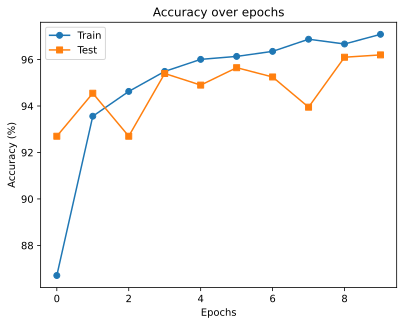

In [7]:
# Run the model without changing the weights; this will be the baseline performance.
# Notice the model creation is outside the function2train
net_base,lossfun,optimizer = createTheMNISTNet()
trainAcc_base,testAcc_base,losses,net_base = function2trainTheModel(net_base,lossfun,optimizer)

# plot the results
plt.plot(range(len(trainAcc_base)),trainAcc_base,'o-', range(len(testAcc_base)),testAcc_base ,'s-')
plt.legend(['Train','Test'])
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

# Set all the weights of layer 1 to zero

In [8]:
# Change the weights before training
net_zero,lossfun,optimizer = createTheMNISTNet()

# set to zeros
net_zero.fc1.weight.data = torch.zeros_like( net_zero.fc1.weight )

# confirm
net_zero.fc1.weight.data

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

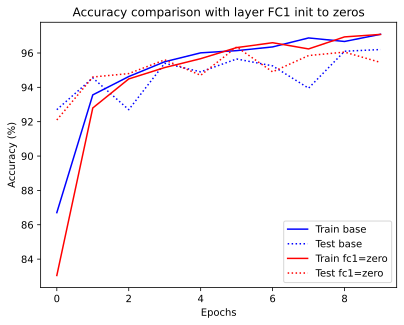

In [9]:
# run the model and show the results
trainAcc_zero,testAcc_zero,losses,net_zero = function2trainTheModel(net_zero,lossfun,optimizer)

plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_zero)),trainAcc_zero,'r-', range(len(testAcc_zero)),testAcc_zero ,'r:')
plt.legend(['Train base','Test base','Train fc1=zero','Test fc1=zero'])
plt.title('Accuracy comparison with layer FC1 init to zeros')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

tensor([[-0.2208,  0.4323,  0.5499,  ...,  0.2422, -0.0599, -0.1625],
        [ 0.1269, -0.6898,  0.2919,  ..., -0.2947, -0.0154,  0.1892],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.9246, -0.9435, -0.0988,  ...,  0.3241, -0.0602, -0.6878],
        [-0.3635, -0.3150, -0.0893,  ..., -0.2471, -0.0244, -0.2196],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


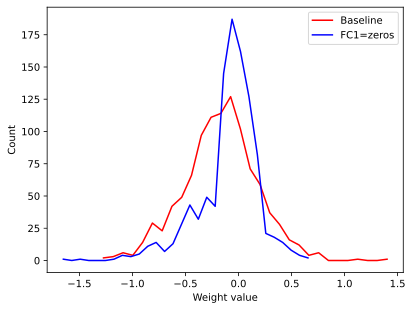

In [10]:
# Are the weights still zeros?
print(net_zero.fc1.weight.data)

# show the distributions in a histogram
y,x = np.histogram(net_base.fc2.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'r',label='Baseline')

y,x = np.histogram(net_zero.fc2.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'b',label='FC1=zeros')

plt.legend()
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.show()

# Let's repeat the experiment with all learnable parameters set to zero

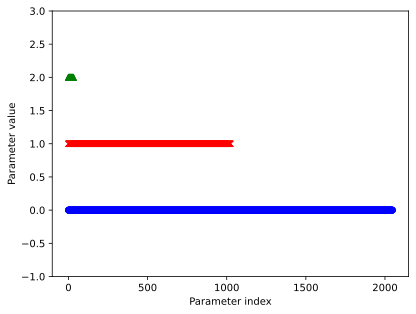

In [11]:
# Change the weights before training
net_allzero,lossfun,optimizer = createTheMNISTNet()

# loop over parameters and set them all to zeros
for p in net_allzero.named_parameters():
  p[1].data = torch.zeros_like( p[1].data )


# and confirm for a few select parameters (y-axis offset for visibility)
plt.plot(0+net_allzero.fc1.weight.data.flatten(),'bo')
plt.plot(1+net_allzero.fc2.weight.data.flatten(),'rx')
plt.plot(2+net_allzero.fc1.bias.data.flatten(),'g^')
plt.xlabel('Parameter index')
plt.ylim([-1,3])
plt.ylabel('Parameter value')
plt.show()

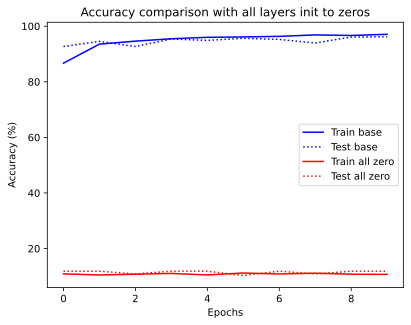

In [12]:
# run the model and show the results
trainAcc_allzero,testAcc_allzero,losses,net_allzero = function2trainTheModel(net_allzero,lossfun,optimizer)

plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_allzero)),trainAcc_allzero,'r-', range(len(testAcc_allzero)),testAcc_allzero ,'r:')
plt.legend(['Train base','Test base','Train all zero','Test all zero'])
plt.title('Accuracy comparison with all layers init to zeros')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

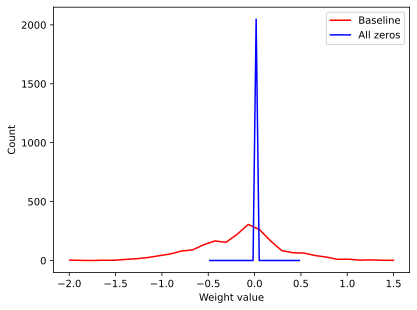

In [13]:
# show the distributions in a histogram
y,x = np.histogram(net_base.fc1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'r',label='Baseline')

y,x = np.histogram(net_allzero.fc1.weight.data.flatten(),30)
plt.plot((x[1:]+x[:-1])/2,y,'b',label='All zeros')

plt.legend()
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.show()

In [ ]:
# woah, not even a single non-zero weight value?!?!!?!!??
plt.plot(net_allzero.fc1.weight.data.flatten(),'o');

# Maybe zero is problematic. What about initializing to 1's?

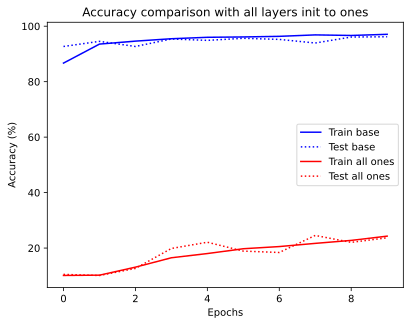

In [14]:
# Change the weights before training
net_allone,lossfun,optimizer = createTheMNISTNet()
for p in net_allone.named_parameters():
  p[1].data = torch.zeros_like( p[1].data ) + 1
  #p[1].data = torch.zeros( p[1].data.shape ) + 1 # equivalent to the previous line!


# run the model and show the results
trainAcc_allone,testAcc_allone,losses,net_allone = function2trainTheModel(net_allone,lossfun,optimizer)

plt.plot(range(len(trainAcc_base)),trainAcc_base,'b-', range(len(testAcc_base)),testAcc_base ,'b:')
plt.plot(range(len(trainAcc_allone)),trainAcc_allone,'r-', range(len(testAcc_allone)),testAcc_allone ,'r:')
plt.legend(['Train base','Test base','Train all ones','Test all ones'])
plt.title('Accuracy comparison with all layers init to ones')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

# Additional explorations

In [ ]:
# 1) You saw that initializing only the weights in fc1 still allowed for good performance, while having all weights be
#    the same value led to HORRIBLE performance. Try setting all weights to ones and all biases to zeros (across all
#    layers). Does that allow for learning? If so, how does it compare to the baseline model performance?
# 
# 2) Now try setting all the weights from all layers to zeros, but leave the bias terms with their initial random values.
# 
# 3) Finally, the opposite of #2: Set all bias terms to zero and leave the weights random. Make a plot of test accuracy
#    performance for the baseline model, weights=0, and biases=0.
# 